In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from gensim.models import Word2Vec
import re

In [ ]:
# Load the pre-trained Word2Vec model
w2v_model = Word2Vec.load("/content/drive/MyDrive/AI_Content_Detector/model_w2v/word2vec_model.model")

In [ ]:
# Load the fitted scaler
scaler = joblib.load('/content/drive/MyDrive/AI_Content_Detector/model_w2v/minmax_scaler.joblib')


In [ ]:
# Load all models into a dictionary
models = {
    "XGBoost": joblib.load('/content/drive/MyDrive/AI_Content_Detector/model_w2v/XGBoost_model.joblib'),
    "SVM_model": joblib.load('/content/drive/MyDrive/AI_Content_Detector/model_w2v/SVM_model.joblib'),
    "Naive_Bayes": joblib.load('/content/drive/MyDrive/AI_Content_Detector/model_w2v/Naive Bayes_model.joblib'),
    "Random_forest": joblib.load('/content/drive/MyDrive/AI_Content_Detector/model_w2v/Random Forest_model.joblib')
}

# Preparing dataset for evaluation

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_syst

In [ ]:
from datasets import load_dataset,concatenate_datasets

ds = load_dataset("Jinyan1/COLING_2025_MGT_en")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/588 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/287M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/286M [00:00<?, ?B/s]

dev-00000-of-00001.parquet:   0%|          | 0.00/246M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/610767 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/261758 [00:00<?, ? examples/s]

In [ ]:
train_dataset = ds['train']

In [ ]:
label_0_samples = train_dataset.filter(lambda x: x['label'] == 0).select(range(2000))
label_1_samples = train_dataset.filter(lambda x: x['label'] == 1).select(range(2000))


Filter:   0%|          | 0/610767 [00:00<?, ? examples/s]

Filter:   0%|          | 0/610767 [00:00<?, ? examples/s]

In [ ]:
balanced_dataset = concatenate_datasets([label_0_samples, label_1_samples]).shuffle(seed=42)


In [ ]:
# Keep only 'label' and 'text' columns
final_dataset = balanced_dataset.remove_columns(['id', 'source', 'sub_source', 'lang', 'model'])

# Print the result
print(final_dataset)

Dataset({
    features: ['label', 'text'],
    num_rows: 4000
})


In [ ]:
# Convert to Pandas DataFrame
data = final_dataset.to_pandas()

# Display first few rows of the DataFrame
print(data.head())

   label                                               text
0      0  small amount of money gets used very often if ...
1      0  Drink some carbonated water with no flavoring ...
2      0  Hateful 8 was shot in a system called [Ultra P...
3      1  The appendix is a small sac-like organ attache...
4      1  [step] Click on the object you have created. E...


# Evaluating trained model on new data

In [ ]:
# Function to convert a corpus of tokenized sentences into vectors using the pre-trained Word2Vec model
def text_to_vector(corpus, model):
    vectors = []
    for words in corpus:
        word_vecs = [model.wv[word] for word in words if word in model.wv]
        if len(word_vecs) > 0:
            vectors.append(np.mean(word_vecs, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))
    return np.array(vectors)


In [ ]:
# Split the dataset into features (text) and labels
X = data['text']
y = data['label']

In [ ]:
# Preprocess the text data (tokenization)
new_corpus = [text.split() for text in X]

In [ ]:
# Vectorize the new dataset
X_new_vectors = text_to_vector(new_corpus, w2v_model)

In [ ]:
X_new_vectors = scaler.transform(X_new_vectors)

Results for XGBoost:
Accuracy: 0.6548
Precision: 0.6611
Recall: 0.6350
F1 Score: 0.6478




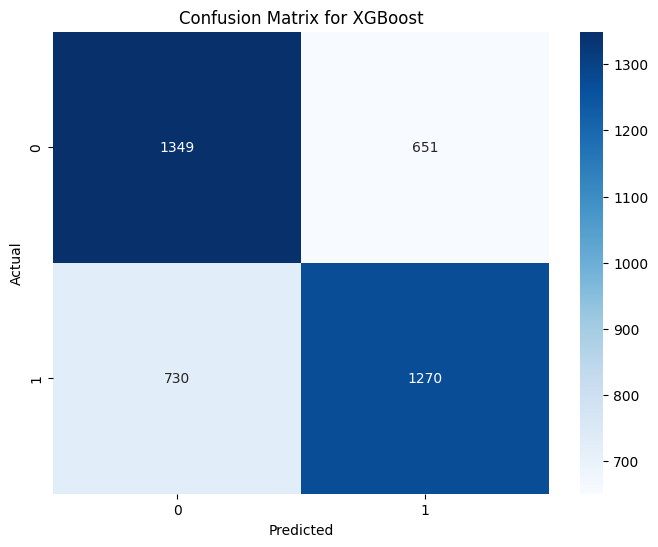

----------------------------------------------------------------------------------------------------
Results for SVM_model:
Accuracy: 0.6515
Precision: 0.6446
Recall: 0.6755
F1 Score: 0.6597




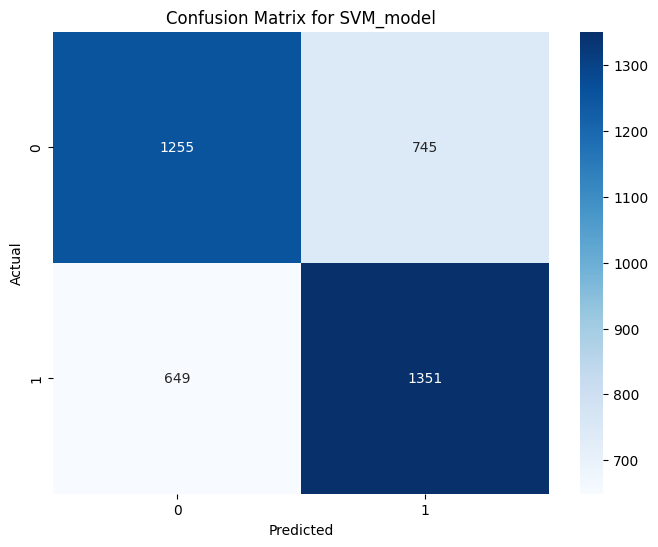

----------------------------------------------------------------------------------------------------
Results for Naive_Bayes:
Accuracy: 0.6125
Precision: 0.5809
Recall: 0.8080
F1 Score: 0.6759




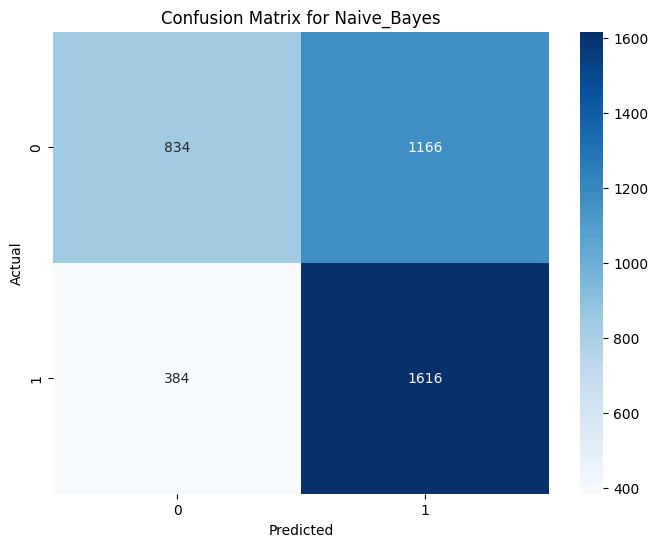

----------------------------------------------------------------------------------------------------
Results for Random_forest:
Accuracy: 0.6575
Precision: 0.6411
Recall: 0.7155
F1 Score: 0.6763




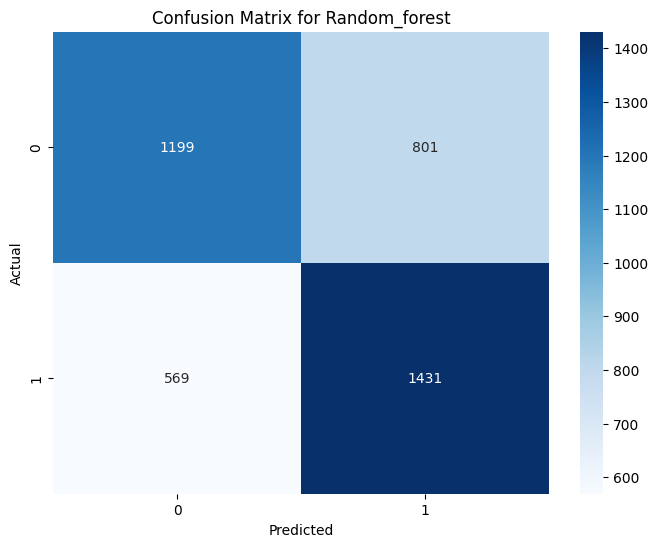

----------------------------------------------------------------------------------------------------


In [ ]:

# Evaluate each model
for model_name, model in models.items():
    # Make predictions
    y_pred = model.predict(X_new_vectors)

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

   # Display metrics
    print(f"Results for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\n")

    # Compute and display confusion matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    print("-" * 100)

